In [1]:
import os
import sys
import shutil

import bw2calc as bc
import bw2data as bd
import bw2io as bi

bi.__version__
bd.__version__
bc.__version__

import seaborn as sns

import visualisation as vis
from add_uncertainties import add_uncertainties
from import_db_from_file import write_database, inspect_db, export_db
from LCA_calculations import get_LCA_scores, get_MCLCA_scores, get_LCA_report
from make_process_diagram import extract_nodes_edges, write_process_diagram

In [2]:
bd.projects.set_current('cLCA-aalborg')
ei = bd.Database('con391')

# Set up models
models = []
models.append("bread") 
models.append('corn')

# set to True if you want to run that function
remove = False
rebuild = True
redo_diagrams = False
recalculate = True
recalculate_MC = True
revisualise = True

# Remove old results folder
if remove == True and os.path.exists('results'):
    shutil.rmtree('results')

# set parameters for Monte Carlo analysis
iterations = 100
scale_percent = 0.3
dist_id = 3
mc_type = ""
if dist_id == 3: mc_type = "Normal_"+str(iterations)
elif dist_id == 2: mc_type = "Lognormal_"+str(iterations)


# set scenarios for testing sensitivity

scenarios = {
    "CoproductsToWaste": False,
    "EnergyEfficient": True,
    "WaterEfficient": False
}

# Write databases from csv files, add uncertainties, inspect and export, make process diagrams
if rebuild == True:
    for model in models:
        write_database(model)
        add_uncertainties(model, dist_id, scale_percent) # see ids below
        inspect_db(model)
        export_db(model)

        if redo_diagrams == True:
            nodes, edges, model = extract_nodes_edges(model)
            write_process_diagram(nodes, edges, model)

fg = bd.Database(f'fg_{model}')


 Writing database for: bread

Deleted old database fg_bread

****** Writing new database: fg_bread
Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 05/24/2023 17:43:48
  Finished: 05/24/2023 17:43:48
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.30
{'depends': ['con391'], 'backend': 'sqlite', 'number': 5, 'modified': '2023-05-24T17:43:48.627201', 'geocollections': [], 'searchable': True, 'processed': '2023-05-24T17:43:48.669648', 'dirty': False}

   ACTIVITY:  
*****************************
Bread waste : kg : Bread waste
----------------------------
	TECHNOSPHERE EXCHANGES: 1
 *  Exchange: 0.0 kg 'Bread waste' (kg, None, None) to 'Bread waste' (kg, None, None)>
----------------------------
	BIOSPHERE EXCHANGES:  0
*****************************

   ACTIVITY:  
*****************************
Purification (bread) : kg : Purification (bread)
-------------------------

In [3]:
for model in models:
    scenario_name = ""
    for k, v in scenarios.items():
        if v == True:
            if k == 'CoproductsToWaste':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='e343521ccabc453ec59738b1d5678118') # 'treatment of biowaste, industrial composting'
                if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill'
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'
            if k == 'EnergyEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'electricity' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            if k == 'WaterEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'water' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            else:
                print("No scenario selected")

    nodes, edges, model = extract_nodes_edges(model)
    write_process_diagram(nodes, edges, model, scenario_name)


***************** Scenario: EnergyEfficient *****************

market group for electricity, medium voltage
Changed edge amount from 0.9 to 0.45 for 
Exchange: 0.45 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, RER, None) to 'Purification (corn)' (kg, None, None)>
market group for electricity, medium voltage
Changed edge amount from 0.9 to 0.45 for 
Exchange: 0.45 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, RER, None) to 'Pre-treatment (corn)' (kg, None, None)>
market group for electricity, medium voltage
Changed edge amount from 0.9 to 0.45 for 
Exchange: 0.45 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, RER, None) to 'Bacterial fermentation (corn)' (kg, None, None)>
No scenario selected


Gtk-Message: 17:43:53.112: Failed to load module "xapp-gtk3-module"



***************** Scenario: EnergyEfficient *****************

market group for electricity, medium voltage
Changed edge amount from 0.45 to 0.225 for 
Exchange: 0.225 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, RER, None) to 'Bacterial fermentation (corn)' (kg, None, None)>
market group for electricity, medium voltage
Changed edge amount from 0.45 to 0.225 for 
Exchange: 0.225 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, RER, None) to 'Pre-treatment (corn)' (kg, None, None)>


../src/intel/isl/isl.c:2216: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.


market group for electricity, medium voltage
Changed edge amount from 0.45 to 0.225 for 
Exchange: 0.225 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, RER, None) to 'Purification (corn)' (kg, None, None)>
No scenario selected


In [4]:
if recalculate == True:
    for model in models:
        lca = get_LCA_scores(model, scenario_name)
        get_LCA_report(model, scenario_name)


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


Gtk-Message: 17:43:54.981: Failed to load module "xapp-gtk3-module"
../src/intel/isl/isl.c:2216: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.




*****************
	 EnergyEfficient: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -26.19 kg CO2-Eq


*****************
	 EnergyEfficient: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -26.19 kg CO2-Eq
reports written to file

***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (corn), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (corn)' (kg, None, None) to 'Succinic acid production (corn)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (corn)' (kg, None, None) to 'Succinic acid production (corn)' (kg, None, None)>


*****************
	 EnergyEfficient: For the FU: 'Succinic acid production (corn)' 1 kg 
	 with the method '('IPCC 


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 EnergyEfficient: For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -26.19 kg CO2-Eq

***************** Monte carlo - LCA calculations *****************



*****************
	 EnergyEfficient : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is (kg CO2-Eq):
 count    100.000000
mean     -27.411782
std        6.822876
min      -

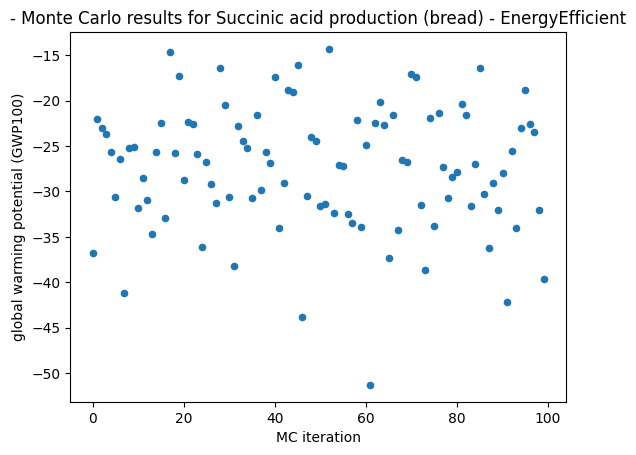

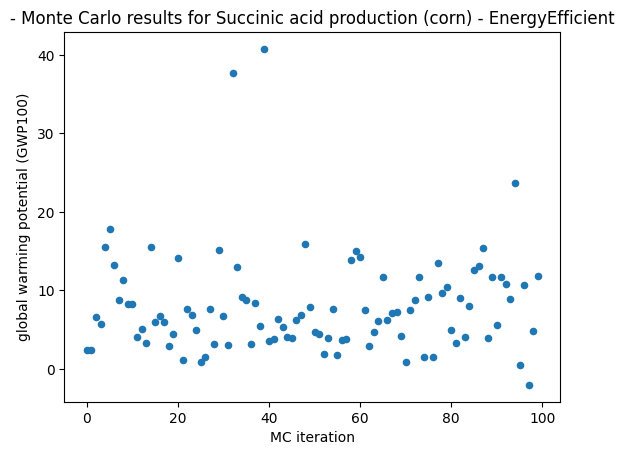

In [5]:
if recalculate_MC == True:
    for model in models:
        single_score = get_LCA_scores(model, scenario_name)
        get_MCLCA_scores(model, single_score, iterations, mc_type, scenario_name)

t = -37.89150409993221
p = 1.90e-92
stat_MW = 0.0
p_PS = 2.56e-34
stat_KS = 1.0
p_KS = 2.21e-59
*** Welch's t-test
stat = -37.89
p = 1.90e-92
*** Mann-Whitney U test
stat = 0.00
p = 2.56e-34
*** Kolmogorov-Smirnov test
stat = 1.00
p = 2.21e-59


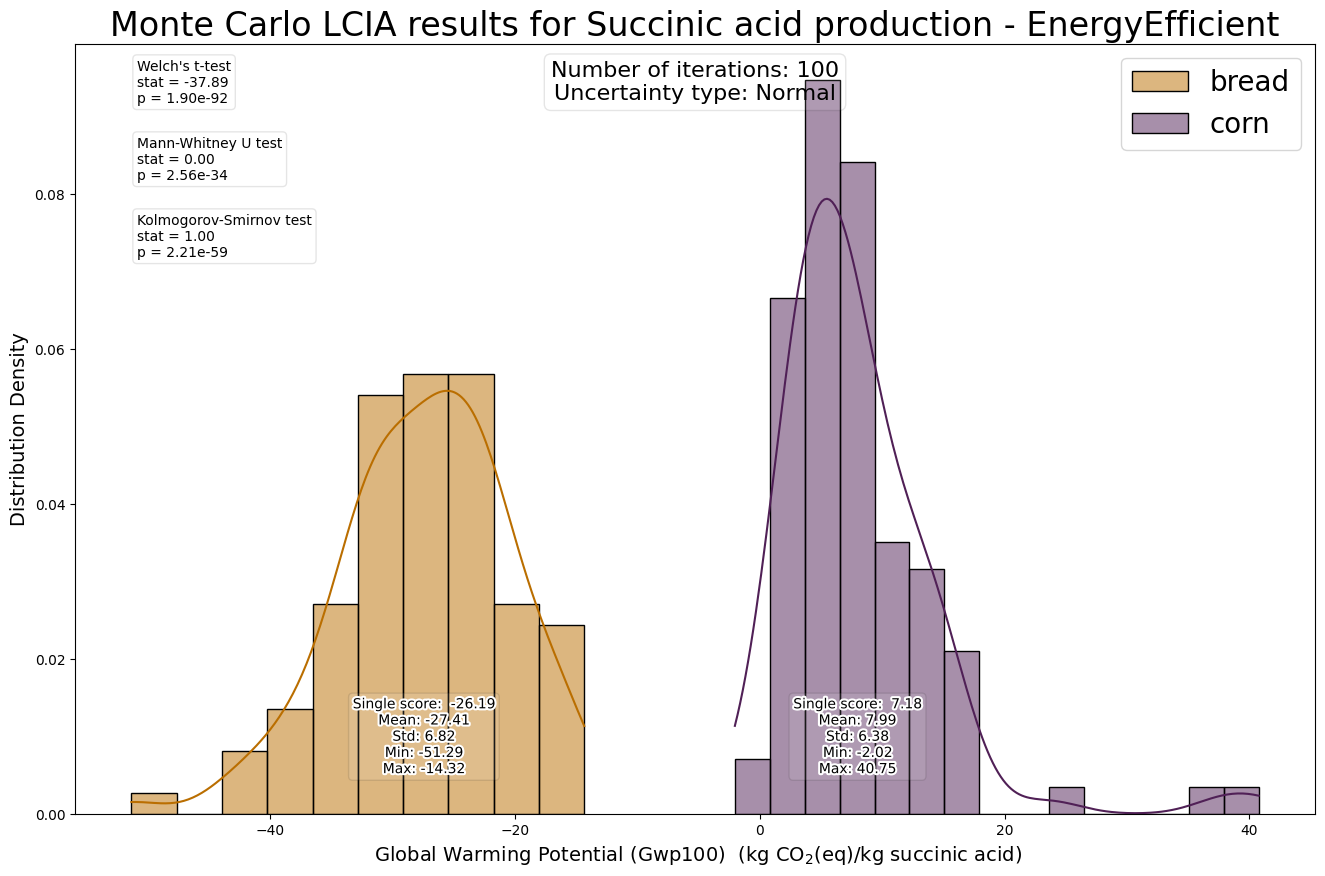

  _________________________________________________
 /                                                 \
| ==== Results for Monte Carlo analysis ====        |
| ***  bread @ global warming potential (GWP100) @  |
| -26.19kg CO2eq / kg  ***                          |
| count, 100.0                                      |
| mean, -27.41178152874114                          |
| std, 6.822875600027229                            |
| min, -51.29489560861505                           |
| 25%, -31.59885706507993                           |
| 50%, -26.79095005255023                           |
| 75%, -22.54352521234243                           |
| max, -14.318055231708582                          |
 \                                                 /
                                                   \
                                                    \
                                                     \
                                                      \
                              

In [6]:
import cowsay 
if revisualise == True:
    df = vis.plot_MC_results(mc_type, scenario_name)
    dic = df.describe().to_dict()

    results_list = []
    results_list.append("==== Results for Monte Carlo analysis ====")
    for key in dic.keys():
        results_list.append("\n***  "  + key + "kg CO2eq / kg  ***")
        for k, v in dic[key].items():
            results_list.append(f"{k}, {v}")
        print(cowsay.turtle('\n'.join(results_list)))
 


# STATS_ARRAYS DISTRIBUTION IDS
#  0: stats_arrays.distributions.undefined.UndefinedUncertainty,
#  1: stats_arrays.distributions.undefined.NoUncertainty,
#  2: stats_arrays.distributions.lognormal.LognormalUncertainty,
#  3: stats_arrays.distributions.normal.NormalUncertainty,
#  4: stats_arrays.distributions.geometric.UniformUncertainty,
#  5: stats_arrays.distributions.geometric.TriangularUncertainty,
#  6: stats_arrays.distributions.bernoulli.BernoulliUncertainty,
#  7: stats_arrays.distributions.discrete_uniform.DiscreteUniform,
#  8: stats_arrays.distributions.weibull.WeibullUncertainty,
#  9: stats_arrays.distributions.gamma.GammaUncertainty,
#  10: stats_arrays.distributions.beta.BetaUncertainty,
#  11: stats_arrays.distributions.extreme.GeneralizedExtremeValueUncertainty,
#  12: stats_arrays.distributions.student.StudentsTUncertaint